In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/03. CODES/object_detection_pytorch/

/content/drive/My Drive/03. CODES/object_detection_pytorch


In [ ]:
! git clone https://github.com/experiencor/raccoon_dataset.git

fatal: destination path 'raccoon_dataset' already exists and is not an empty directory.


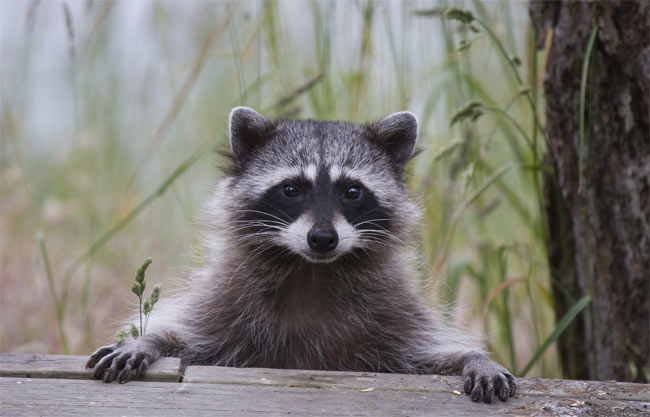

In [ ]:
from PIL import Image
image = Image.open("raccoon_dataset/images/raccoon-1.jpg")
image

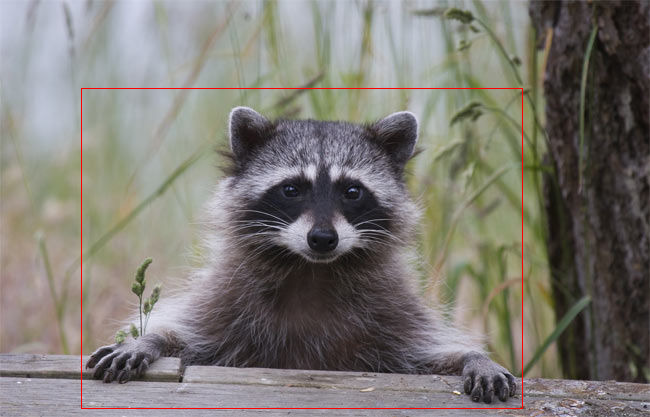

In [ ]:
# just wanna inspect the bbox
from PIL import ImageDraw
xmin = 81
ymin = 88
xmax = 522
ymax = 408
draw = ImageDraw.Draw(image)
draw.rectangle([(xmin, ymin), (xmax, ymax)], outline ="red")
image

In [ ]:
import pandas as pd
labels = pd.read_csv("raccoon_dataset/data/raccoon_labels.csv")
labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-1.jpg,650,417,raccoon,81,88,522,408
1,raccoon-10.jpg,450,495,raccoon,130,2,446,488
2,raccoon-100.jpg,960,576,raccoon,548,10,954,520
3,raccoon-101.jpg,640,426,raccoon,86,53,400,356
4,raccoon-102.jpg,259,194,raccoon,1,1,118,152


In [ ]:
import os 
os.getcwd()
cd /content/drive/My Drive/03. CODES/object_detection_pytorch/

/content/drive/My Drive/03. CODES/object_detection_pytorch


**Clone the PyTorch vision repo and copy some python files**
> Indented block



In [ ]:
%%bash
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

Cloning into 'vision'...
Checking out files: 100% (490/490), done.
error: Your local changes to the following files would be overwritten by checkout:
	.circleci/regenerate.py
	.circleci/unittest/linux/scripts/install.sh
	.circleci/unittest/linux/scripts/post_process.sh
	.circleci/unittest/linux/scripts/run_test.sh
	.circleci/unittest/linux/scripts/setup_env.sh
	packaging/build_cmake.sh
	packaging/build_conda.sh
	packaging/build_wheel.sh
	packaging/conda/build_vision.sh
	packaging/conda/switch_cuda_version.sh
	travis-scripts/run-clang-format/run-clang-format.py
Please commit your changes or stash them before you switch branches.
Aborting


In [ ]:
import shutil
# shutil.move("vision/references/detection/utils.py", "/content/drive/My Drive/03. CODES/object_detection_pytorch")
# shutil.move("vision/references/detection/transforms.py", "/content/drive/My Drive/03. CODES/object_detection_pytorch")

'/content/drive/My Drive/03. CODES/object_detection_pytorch/transforms.py'

In [ ]:
# shutil.move("vision/references/detection/coco_eval.py", "/content/drive/My Drive/03. CODES/object_detection_pytorch")
# shutil.move("vision/references/detection/engine.py", "/content/drive/My Drive/03. CODES/object_detection_pytorch")
# shutil.move("vision/references/detection/coco_utils.py", "/content/drive/My Drive/03. CODES/object_detection_pytorch")

'/content/drive/My Drive/03. CODES/object_detection_pytorch/coco_utils.py'

In [ ]:
# import packages
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T

**Preparing the data**

The class needs to inherit from torch.utils.data.Dataset and implement the __getitem__ and __len__ methods. We already have the raccoon_labels.csv file containing all the parsed annotations, all we have to do is write a little helper function:

In [ ]:
def parse_one_annot(path_to_data_file, filename):
   data = pd.read_csv(path_to_data_file)
   boxes_array = data[data["filename"] == filename][["xmin", "ymin",        
   "xmax", "ymax"]].values
   
   return boxes_array

In [ ]:
class RaccoonDataset(torch.utils.data.Dataset):
   def __init__(self, root, data_file, transforms=None):
       self.root = root
       self.transforms = transforms
       self.imgs = sorted(os.listdir(os.path.join(root, "images")))
       self.path_to_data_file = data_file
   def __getitem__(self, idx):
      # load images and bounding boxes
      img_path = os.path.join(self.root, "images", self.imgs[idx])
      img = Image.open(img_path).convert("RGB")
      box_list = parse_one_annot(self.path_to_data_file, 
      self.imgs[idx])
      boxes = torch.as_tensor(box_list, dtype=torch.float32)
      num_objs = len(box_list)
      # there is only one class
      labels = torch.ones((num_objs,), dtype=torch.int64)
      image_id = torch.tensor([idx])
      area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,
      0])
      # suppose all instances are not crowd
      iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
      target = {}
      target["boxes"] = boxes
      target["labels"] = labels
      target["image_id"] = image_id
      target["area"] = area
      target["iscrowd"] = iscrowd


      if self.transforms is not None:
         img, target = self.transforms(img, target)
      return img, target


   def __len__(self):
         return len(self.imgs)

In [ ]:
dataset = RaccoonDataset(root= "raccoon_dataset",
data_file= "raccoon_dataset/data/raccoon_labels.csv")
dataset.__getitem__(0)

(<PIL.Image.Image image mode=RGB size=650x417 at 0x7F17A4E03668>,
 {'area': tensor([141120.]),
  'boxes': tensor([[ 81.,  88., 522., 408.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0]),
  'labels': tensor([1])})

In [ ]:
def get_model(num_classes):
   # load an object detection model pre-trained on COCO
   model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
   # get the number of input features for the classifier
   in_features = model.roi_heads.box_predictor.cls_score.in_features
   # replace the pre-trained head with a new on
   model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
   
   return model

In [ ]:
# data augmentation
def get_transform(train):
   transforms = []
   # converts the image, a PIL image, into a PyTorch Tensor
   transforms.append(T.ToTensor())
   if train:
      # during training, randomly flip the training images
      # and ground-truth for data augmentation
      transforms.append(T.RandomHorizontalFlip(0.5))
   return T.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
dataset = RaccoonDataset(root= "raccoon_dataset",
                         data_file= "raccoon_dataset/data/raccoon_labels.csv",
                         transforms = get_transform(train=True))
dataset_test = RaccoonDataset(root= "raccoon_dataset",
                              data_file= "raccoon_dataset/data/raccoon_labels.csv",
                              transforms = get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)

print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

We have: 200 examples, 160 are training and 40 testing


**Train the model**

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# our dataset has two classes only - raccoon and not racoon
num_classes = 2
# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# let's train it for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
   # train for one epoch, printing every 10 iterations
   train_one_epoch(model, optimizer, data_loader, device, epoch,
                   print_freq=10)
   # update the learning rate
   lr_scheduler.step()
   # evaluate on the test dataset
   evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/80]  eta: 0:02:17  lr: 0.000068  loss: 1.4562 (1.4562)  loss_classifier: 1.3221 (1.3221)  loss_box_reg: 0.1101 (0.1101)  loss_objectness: 0.0035 (0.0035)  loss_rpn_box_reg: 0.0205 (0.0205)  time: 1.7214  data: 0.8258  max mem: 2419
Epoch: [0]  [10/80]  eta: 0:00:45  lr: 0.000701  loss: 0.7903 (0.8574)  loss_classifier: 0.6560 (0.7009)  loss_box_reg: 0.1504 (0.1440)  loss_objectness: 0.0035 (0.0044)  loss_rpn_box_reg: 0.0062 (0.0082)  time: 0.6529  data: 0.0813  max mem: 2824
Epoch: [0]  [20/80]  eta: 0:00:36  lr: 0.001333  loss: 0.2846 (0.5705)  loss_classifier: 0.1391 (0.4289)  loss_box_reg: 0.1240 (0.1288)  loss_objectness: 0.0034 (0.0042)  loss_rpn_box_reg: 0.0062 (0.0086)  time: 0.5473  data: 0.0066  max mem: 3188
Epoch: [0]  [30/80]  eta: 0:00:30  lr: 0.001965  loss: 0.2365 (0.4599)  loss_classifier: 0.1153 (0.3204)  loss_box_reg: 0.1130 (0.1235)  loss_objectness: 0.0034 (0.0049)  loss_rpn_box_reg: 0.0080 (0.0111)  time: 0.5931  data: 0.0065  max mem: 3566
Epoch: [

In [ ]:
import os 
os.getcwd()

'/content/drive/My Drive/03. CODES/object_detection_pytorch'

In [ ]:
os.mkdir("raccoon/")
torch.save(model.state_dict(), "raccoon/model")

In [ ]:
# load the model
loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load("raccoon/model"))

<All keys matched successfully>

In [ ]:
idx = 0
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])
#put the model in evaluation mode
loaded_model.eval()
with torch.no_grad():
   prediction = loaded_model([img])
image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)
# draw groundtruth
for elem in range(len(label_boxes)):
   draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
   (label_boxes[elem][2], label_boxes[elem][3])], 
   outline ="green", width =3)
for element in range(len(prediction[0]["boxes"])):
   boxes = prediction[0]["boxes"][element].cpu().numpy()
   score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
   if score > 0.8:
      draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
      outline ="red", width =3)
      draw.text((boxes[0], boxes[1]), text = str(score))

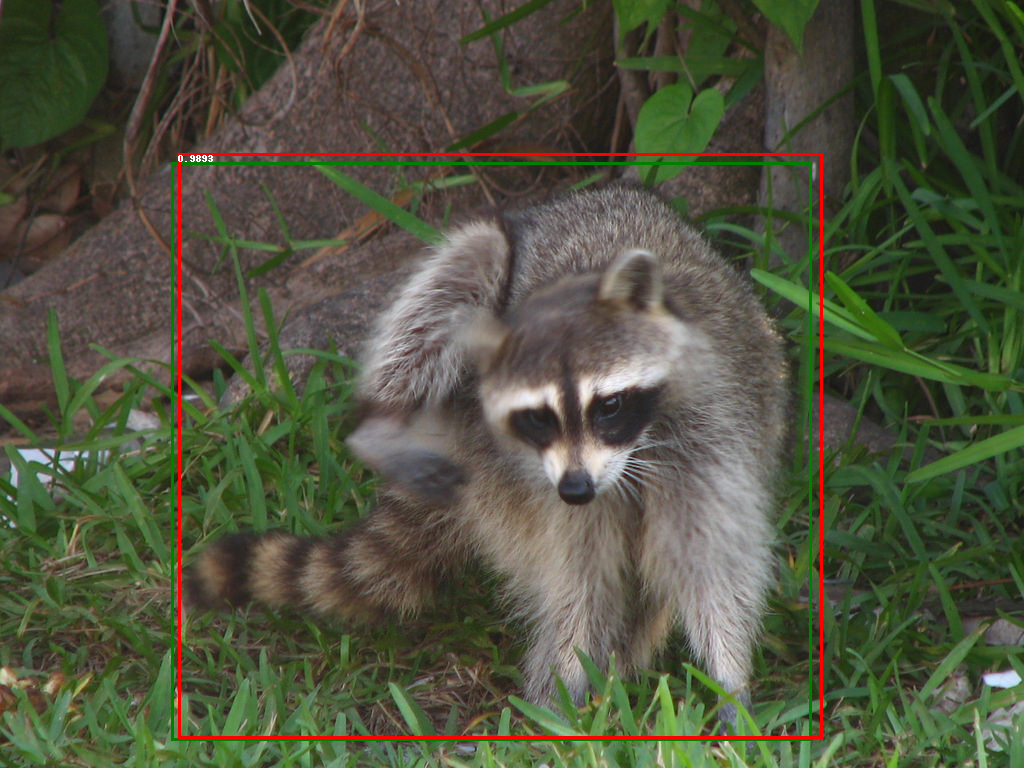

In [ ]:
image